# Spotify Music Recommender Prioritizing Discovering New Artists/Music
## Team 47 

- Brian Yang (yang.bria@northeastern.edu)
- Gerri Fox (fox.ge@northeastern.edu)
- Spencer Solomon (solomon.sp@northeastern.edu)

#### Reuse Permissions
The following may be re-used for any purposes:
- all data included with submission
- all images
- this and other jupyter notebooks
- the associated [video presentation](https://northeastern-my.sharepoint.com/personal/yang_bria_northeastern_edu/Documents/Attachments/DS3000%20team%2047%20presentation.mp4)

Please attribute any work to the authors listed above.


# Executive Summary
We build a song recommendation system by analyzing Spotify song data from [Kaggle](https://www.kaggle.com/edalrami/19000-spotify-songs) and collecting supplementary listen counts by scraping the view counts of those songs on Youtube. Our recommender works by identifying the five closest songs in terms of Euclidean distance between song audio features. To account for features that may be correlated (ex. energy and loudness), we [apply Principal component analysis (PCA)](#pca) to all our features in order to obtain a more concise set of variables with more explainable variance. Because we don't have a way to measure if a recommended song is "valid", [it is difficult to validate our recommender](#validation). We explored the idea of user-centric feedback, but realize that music listeners are bias as well in terms of their preferences. The best we could consider would be an "at a glance" sanity check to see if the given song's genre is represented in the recommendations. We found that this result varied across genres, suggesting that different genres may be more inclusive than others.

# Ethical Considerations
If a solid connection between listener enjoyment and audio features is established, the music industry may find it more profitable to create music built for popularity rather than artistic value. Of course, this already happens, as there is a distinct "popular" or pop genre. We believe that by prioritizing music from lesser known artists, our system would not feed into the industry monetary pull.

# Introduction
Finding new music to listen to is always a hard task. Many times people will ask their friends for new music, however, everyone has their own personalized tastes. Hence, friends aren't always a great resource. Spotify is one of the largest streaming services in the world which has a large dataset on Kaggle with tons of information. With this dataset from Kaggle we're hoping to make a relationship between audio features (energy, tempo, danceability, etc.) to find other songs that the user will enjoy based on a given song. **This project aims to reccomend new songs to a listener based on another song they enjoy.** To raise the chance of recommending a song that the user has not already heard, our goal is to prioritize recommending music from lesser known artists.

# Data Description

In [1]:
import pandas as pd
import numpy as np
import requests
import json
from bs4 import BeautifulSoup
from selenium import webdriver
from tqdm import tqdm
import os
import math
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsTransformer
from sklearn.model_selection import StratifiedKFold
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [2]:
song_data_not_clean = pd.read_csv('all_songs_not_clean.csv')
del song_data_not_clean['Unnamed: 0']

In [3]:
song_data_cleaned = pd.read_csv('all_songs_clean.csv')
del song_data_cleaned['Unnamed: 0']
song_data_cleaned = song_data_cleaned.drop_duplicates()

In [4]:
song_data_cleaned.head()

,acousticness,album_names,artist_name,audio_mode,audio_valence,danceability,energy,instrumentalness,key,liveness,loudness,song_duration_ms,song_name,song_popularity,speechiness,tempo,time_signature,yt_max_views
0,0.000954,Silver Side Up,Nickelback,1.0,0.574,0.447,0.766,0.000000,10.0,0.113,-5.065,223826.0,How You Remind Me,56.0,0.0313,172.011,4.0,73000000.0
1,0.013700,No One Knows (International Version),Queens of the Stone Age,1.0,0.687,0.518,0.538,0.000398,0.0,0.141,-5.818,255066.0,No One Knows,13.0,0.0486,170.953,4.0,128000000.0
2,0.010200,Come Clean (Repackaged International Version),Puddle Of Mudd,0.0,0.495,0.440,0.932,0.000000,3.0,0.142,-4.488,303920.0,Blurry,28.0,0.0584,157.438,4.0,82000000.0
3,0.000194,ONE BY ONE,Foo Fighters,1.0,0.674,0.582,0.597,0.000273,5.0,0.517,-5.671,262733.0,All My Life,11.0,0.0512,167.738,4.0,84000000.0
4,0.000917,"Echoes, Silence, Patience & Grace",Foo Fighters,1.0,0.365,0.433,0.959,0.000000,9.0,0.028,-4.040,269373.0,The Pretender,11.0,0.0431,172.984,4.0,457000000.0


Data Sources:
    
- [Kaggle](https://www.kaggle.com/edalrami/19000-spotify-songs)    
- [YouTube](youtube.com)

In order to get data by which we could compare songs and determine similarity, we utilized two main data sources: Kaggle and YouTube. The Kaggle dataset consists of 19,000 songs and contains identifying information such as track name and artist name, and several audio features, for each song. Some examples of these audio features include 'energy', 'tempo', 'instrumentalness' and 'loudness', among others. We will use these audio features in order to determine similarity between songs. The Kaggle database also contains Spotify popularity values for each song, however these songs are on a 0-100 relative scale, which can be difficult to interpert. In order to validate the this scale, and see how it translates to real listener values, we scraped the number of views each song had from YouTube and plotted the results to compare the real view values to the Spotify popularity values. Both Spotify popularity and YouTube views are included in the above dataframe.

# Method

The first Machine Learning technique we applied to our data was [Principle Component Analysis (PCA)](https://www.edureka.co/blog/principal-component-analysis/). Since many of our features are correlated, such as tempo and energy, applying any Machine Learning model to our raw data would result in some overcounting of the effects of correlated features. 

**Below we can see that some features such as energy and loudness (positive) energy and acousticness (negative) for example.**

In [5]:
x_feats = ['acousticness', 'audio_mode', 'audio_valence', 'danceability', 'energy', 
           'instrumentalness', 'loudness', 'speechiness', 'tempo']

In [6]:
song_data_cleaned.loc[:, x_feats].corr()

,acousticness,audio_mode,audio_valence,danceability,energy,instrumentalness,loudness,speechiness,tempo
acousticness,1.000000,0.059293,-0.086826,-0.143831,-0.660038,0.124031,-0.547157,-0.062955,-0.146908
audio_mode,0.059293,1.000000,0.006369,-0.106097,-0.042704,-0.036195,-0.049482,-0.106707,0.030207
audio_valence,-0.086826,0.006369,1.000000,0.357277,0.288050,-0.215622,0.196963,0.009149,0.060894
danceability,-0.143831,-0.106097,0.357277,1.000000,0.028336,-0.102679,0.136163,0.193897,-0.127597
energy,-0.660038,-0.042704,0.288050,0.028336,1.000000,-0.185297,0.766816,0.068316,0.189006
instrumentalness,0.124031,-0.036195,-0.215622,-0.102679,-0.185297,1.000000,-0.342069,-0.070383,-0.031735
loudness,-0.547157,-0.049482,0.196963,0.136163,0.766816,-0.342069,1.000000,0.063836,0.143706
speechiness,-0.062955,-0.106707,0.009149,0.193897,0.068316,-0.070383,0.063836,1.000000,0.028307
tempo,-0.146908,0.030207,0.060894,-0.127597,0.189006,-0.031735,0.143706,0.028307,1.000000


Another issue with our data is the difference in scales between different features. This would cause features with larger units, such as tempo, to have a larger impact on our final recommendations. 

**Below we can see that loudness and tempo especially have much larger features than the rest of the features.**

In [7]:
song_data_cleaned.loc[:, x_feats].var().sort_values()

speechiness           0.011292
danceability          0.025795
energy                0.050176
audio_valence         0.063849
instrumentalness      0.067365
acousticness          0.091134
audio_mode            0.232056
loudness             15.970504
tempo               850.277560
dtype: float64

PCA solves both of these issues by normalizing and decorrelating our data. After applying PCA, our features no longer directly correspond to our original audio features, but our new "PCA-ed" features will no longer have the issues disscussed before.

Once we have removed the correlation from our features and normalized their scale, we can begin applying a machine learning model to determine which songs are most similar. In order to accomplish this task, we will use a [K Nearest Neighbors (KNN) Classifier](https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761). To put it simply, KNN plots each of the songs in n-dimensional space, with each dimension corresponding to an audio feature of the song. Similarity is then determined by the distance between songs in the graph. One pitfall of this method is that there is no meaningful way to extract a ranking of feature importance from our model. As such, we cannot know which audio features were most important in determining similarity, however this is likely acceptable for our application, as we want all of our features to be weighted equally in order to get the best estimate of song similarity. Another pitfall is that there is no true way to know how closely distance in our KNN grpah correlates to the "true" similarity between two songs. Song reccomendations are extremely subjective, and as such it is almost impossible to find an accurate way to validate the results achieved from our model in any meaningful way. 

# Results

## Estimation

First, we applied PCA to our data because some of the features we are using to evaluate songs are correlated and we do not want to predict based on double counting an aspect. We chose specific features to include in our predictions as some from the Kaggle dataset/Spotify API we deemed not as important or not helpful for our recommendations. For example, we chose not to include liveness or time signature as whether a song is live or not does not really have an effect on the contents and there can be a wide range of songs in the same time signature. Then, we used KNeighborsTransformer and fit it to the data after applying PCA. We used this as our predictor does not have any correct values to train with thus this version of KNN was best suited.

<a id='pca'></a>

In [8]:
# features to use in our predictor
x_feats = ['acousticness', 'audio_mode', 'audio_valence', 'danceability', 'energy', 
           'instrumentalness', 'loudness', 'speechiness', 'tempo']

# get data using the above features
x = song_data_cleaned.loc[:, x_feats].values

# apply pca on data
pca = PCA(whiten=True)
pca_data = pca.fit_transform(x)

# initialize a KNN object with the data after applying PCA
knn = KNeighborsTransformer()
knn = knn.fit(pca_data)

The next method is what takes an inputted song and artist and predicts the top 5 closest songs. If the inputted song is in the cleaned dataset, then the predictor obviously finds the song itself thus we have a check to determine if this is the case, and then exclude it from the predictions. We get our predictions by calling knn.kneighbors for 6 neighbors to account for the possibility that the song itself is the top recommendation. If the song is not in the prediction, then we exclude that 6th prediction to return the top 5.

In [9]:
def recommend_songs(song_name, artist_name):
    """ Recommends a list of 5 songs based on the input song
    
    Args:
        song_name (str): The name of the song to get recommendations based on
        artist_name (str): The name of the artist of the song to get recommendations based on
    
    Returns:
        songs (list) : A list of song names and artists which are recommended based on the users requested song
    """
        
    # get features of inputted song
    song_data = get_spotify_data(song_name, artist_name)
    
    # reshape inputted song data
    song_data = song_data.reshape((-1, 1))
    song_data = np.transpose(song_data)

    # get a prediction of the top 6 songs based on the inputted song features
    prediction = knn.kneighbors(X=song_data, n_neighbors=6, return_distance=True)
    prediction = prediction[1][0]
    
    similar_songs = song_data_not_clean.iloc[prediction, :]
    
    # determine if the inputted song is within the training data, if so then exclude it in the prediction 
    if song_name in similar_songs['song_name'].values and artist_name in similar_songs['artist_name']:
        similar_songs = similar_songs.iloc[1:]
    else:
        similar_songs = similar_songs[:-1]
        
    # print the recommendations 
    songs = f'The songs most similar to {song_name.title()} by {artist_name.title()} are: \n'
    
    for i, sim_song in similar_songs.iterrows():        
        song_name = sim_song['song_name']
        artist_name = sim_song['artist_name']
        
        songs += f'\t{song_name} by {artist_name} \n'
        
    return songs

This function takes in a song name and artist name and queries the spotify api to get its features that we are using to predict. This is necessary as we want our recommender to be able to work on all songs in Spotify, not just those in our database. 

In [10]:
def get_spotify_data(song_name, artist_name):
    '''Gets the features of the given song from Spotify
    
    Args:
        song_name (str): The name of the song to get recommendations based on
        artist_name (str): The name of the artist of the song to get recommendations based on
    
    Returns:
        features (list) : A list of features of the inputted song
    '''
    
    # the x features we are using to predict based on
    x_feats = ['acousticness', 'mode', 'valence', 'danceability', 'energy', 
           'instrumentalness', 'loudness', 'speechiness', 'tempo']
    
    client_id = '8c43c3614cb54ce89502cbbfaf61f69a'
    client_secret = '9de569c5aad4453b8d3c285291f0de78'
    
    cred_man = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=cred_man)
    
    # format the song and artist name for the query 
    song_name = song_name.replace(' ', '+')
    artist_name = artist_name.replace(' ', '+')
    
    query = f'{song_name}+{artist_name}'
    
    track = sp.search(query, 1,  0, 'track', None)
    
    track_id = track['tracks']['items'][0]['id']
    
    audio_features = sp.audio_features([track_id])[0]
    
    # get the features and put them in a list 
    features = np.array([])
    for feat in x_feats:
        features = np.append(features, audio_features[feat])
    
    return features

## Validation

<a id='validation'></a>

There doesn't really exist a formal way to validate our model. One potential way we could test our results is by conducting user surveys where we ask people to input a song they like, and then they listen to the 5 top songs our model recommends, and then report back whether they like them or not. This is very subjective and not a sure fire way to validate however. Another approach we could do it analyzing and comparing the Spotify features of the input song to the recommended song. This is a quantative approach but does not consider whether the user is actually satisfied with the recommendations. 

For our validation, we have done some of both of the above methods. After testing on users all with different genre preferences, these are the conclusions:

Now, I will use the same data as above and compare the features of the inputted song versus those of the recommended songs. I will collect data predicting for songs of different genres and analyze the different features of each of the top predicted songs from each method in comparison to the input song.

In [11]:
# features to use in our predictor
x_feats = ['acousticness', 'audio_mode', 'audio_valence', 'danceability', 'energy', 
           'instrumentalness', 'loudness', 'speechiness', 'tempo']

# get data using the above features
x = song_data_cleaned.loc[:, x_feats].values

# apply pca on data
pca = PCA(whiten=True)
pca_data = pca.fit_transform(x)

# initialize a KNN object with the data after applying PCA
knn = KNeighborsTransformer()
knn = knn.fit(pca_data)

In [12]:
def recommend_songs(song_name, artist_name):
    """ Recommends a list of 5 songs based on the input song
    
    Args:
        song_name (str): The name of the song to get recommendations based on
        artist_name (str): The name of the artist of the song to get recommendations based on
    
    Returns:
        songs (list) : A list of song names and artists which are recommended based on the users requested song
    """
        
    # get features of inputted song
    song_data = get_spotify_data(song_name, artist_name)
    
    # reshape inputted song data
    song_data = song_data.reshape((-1, 1))
    song_data = np.transpose(song_data)

    # get a prediction of the top 6 songs based on the inputted song features
    prediction = knn.kneighbors(X=song_data, n_neighbors=6, return_distance=True)
    prediction = prediction[1][0]
    
    similar_songs = song_data_not_clean.iloc[prediction, :]
    
    # determine if the inputted song is within the training data, if so then exclude it in the prediction 
    if song_name in similar_songs['song_name'].values and artist_name in similar_songs['artist_name']:
        similar_songs = similar_songs.iloc[1:]
    else:
        similar_songs = similar_songs[:-1]
        
    # print the recommendations 
    songs = f'The songs most similar to {song_name.title()} by {artist_name.title()} are: \n'
    
    for i, sim_song in similar_songs.iterrows():        
        song_name = sim_song['song_name']
        artist_name = sim_song['artist_name']
        
        songs += f'\t{song_name} by {artist_name} \n'
        
    return songs

In [13]:
def get_spotify_data(song_name, artist_name):
    '''Gets the features of the given song from Spotify
    
    Args:
        song_name (str): The name of the song to get recommendations based on
        artist_name (str): The name of the artist of the song to get recommendations based on
    
    Returns:
        features (list) : A list of features of the inputted song
    '''
    
    # the x features we are using to predict based on
    x_feats = ['acousticness', 'mode', 'valence', 'danceability', 'energy', 
           'instrumentalness', 'loudness', 'speechiness', 'tempo']
    
    client_id = '8c43c3614cb54ce89502cbbfaf61f69a'
    client_secret = '9de569c5aad4453b8d3c285291f0de78'
    
    cred_man = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=cred_man)
    
    # format the song and artist name for the query 
    song_name = song_name.replace(' ', '+')
    artist_name = artist_name.replace(' ', '+')
    
    query = f'{song_name}+{artist_name}'
    
    track = sp.search(query, 1,  0, 'track', None)
    
    track_id = track['tracks']['items'][0]['id']
    
    audio_features = sp.audio_features([track_id])[0]
    
    # get the features and put them in a list 
    features = np.array([])
    for feat in x_feats:
        features = np.append(features, audio_features[feat])
    
    return features

In [14]:
# testing on songs of differing genres/sounds (classic rock, acoustic, rap, pop)

test_songs = ['start me up', 'thinking out loud', 'fefe', 'Levitating']
test_artists = ['rolling stones', 'ed sheeran', '6ix9ine', 'Dua Lipa']

for song,artist in zip(test_songs,test_artists):
    songs = recommend_songs(song, artist)

    print(songs)

The songs most similar to Start Me Up by Rolling Stones are: 
	Backin' It Up (feat. Cardi B) by Pardison Fontaine 
	GDFR (feat. Sage The Gemini & Lookas) by Flo Rida 
	Better Off Alone by Ryan Pulford 
	Ridin' My Thumb To Mexico by Johnny Rodriguez 
	Hold On, I'm Comin' by Sam & Dave 

The songs most similar to Thinking Out Loud by Ed Sheeran are: 
	Just Tell Me by Nico Yaryan 
	Anthem by Dzeko 
	Flames by David Guetta 
	Always Like This by Bombay Bicycle Club 
	Good Riddance (Time of Your Life) by Green Day 

The songs most similar to Fefe by 6Ix9Ine are: 
	Look What I Found by Lady Gaga 
	100 Miles and Running (ft. Wale & John Lindahl) by Logic 
	Vroom (feat. Yung Pinch & 03 Greedo) by Hit-Boy 
	Last Call by Hudson Thames 
	I'm Just Snacking by Gus Dapperton 

The songs most similar to Levitating by Dua Lipa are: 
	My Girl by The Temptations 
	All Eyez On Me by 2Pac 
	Lost In Love by Nastyboy Klick 
	The Heat by Jungle 
	Spread Love (Paddington) [feat. DVNO] by Boston Bun 



Since there really is no sure fire way to validate our model as it is prediction based and individualized and subjective, along with just comparing the raw features and numbers, we conducted some manual user testing. We have had multiple users provide a song they enjoy, have our model predict 5 songs based on it, and then had each person listen to their recommendations and provide feedback. Overall, the feedback was positive in that they enjoyed the songs that were recommended, and could hear some similarities such as with tempo and sound mainly, but also felt that the recommended songs were not perfect, spot on matches, as for example, often the genres differed. 

### Visualization
Now, I used the same data as above and graphed each inputted song's features next to those of the recommended songs, to visualize the relationships between songs. I also have a graph comparing each genre next to each other to see if genre has any effect.  

In [15]:
def recommend_songs_visualization(song_name, artist_name):
    """ Recommends a list of 5 songs based on the input song
    
    Args:
        song_name (str): The name of the song to get recommendations based on
        artist_name (str): The name of the artist of the song to get recommendations based on
    
    Returns:
        songs (list) : A list of song names and artists which are recommended based on the users requested song
        similar_songs (pd.DataFrame): A Dataframe of all predicted songs and features
        song_data (np.array): an array of the song features for the inputted song
    """
        
    # get features of inputted song
    song_data = get_spotify_data(song_name, artist_name)
    
    # reshape inputted song data
    song_data = song_data.reshape((-1, 1))
    song_data = np.transpose(song_data)

    # get a prediction of the top 6 songs based on the inputted song features
    prediction = knn.kneighbors(X=song_data, n_neighbors=6, return_distance=True)
    prediction = prediction[1][0]
    
    similar_songs = song_data_not_clean.iloc[prediction, :]
    
    # determine if the inputted song is within the training data, if so then exclude it in the prediction 
    if song_name in similar_songs['song_name'].values and artist_name in similar_songs['artist_name']:
        similar_songs = similar_songs.iloc[1:]
    else:
        similar_songs = similar_songs[:-1]
        
    # print the recommendations 
    songs = f'The songs most similar to {song_name.title()} by {artist_name.title()} are: \n'
    
    for i, sim_song in similar_songs.iterrows():        
        song_name = sim_song['song_name']
        artist_name = sim_song['artist_name']
        
        songs += f'\t{song_name} by {artist_name} \n'
        
        
    return songs, similar_songs, song_data

In [16]:
# testing on songs of all different genres
# building data lists to put in dataframe to visualization purposes

test_songs = ['start me up', 'thinking out loud', 'fefe', 'Levitating']
test_artists = ['rolling stones', 'ed sheeran', '6ix9ine', 'Dua Lipa']

# the x features we are using to predict based on plus song name
x_feats = ['song_name','acousticness', 'audio_mode', 'audio_valence', 'danceability', 'energy', 
           'instrumentalness', 'loudness', 'speechiness', 'tempo']

# initializing lists of features
index = []
acousticness = []
mode =  []
valence =  []
danceability =  []
energy =  []
instrumentalness =  []
loudness =  []
speechiness =  []
tempo =  []

# put data lists in an array
data = [index,acousticness,mode,valence,danceability,energy, instrumentalness,loudness,speechiness,tempo]

# counter to go through features for input song data
counter = list(range(0,11))

# go through every input song
for song,artist in zip(test_songs,test_artists):
    # get predictions
    songs,predictions,song_data = recommend_songs_visualization(song, artist)
    # add the data for the inputted song itself
    for data_list,count in zip(data,counter):
        # add song name 
        if count == 0:
            data_list.append(song)
        # add rest of features
        else:
            ct_idx = count-1
            data_list.append(song_data[0][ct_idx])
    # add all features for predicted songs
    for idx in range(5):
        for feat,data_list in zip(x_feats,data):
            data_list.append(predictions[idx:idx+1][feat].values[0])

Below is a dataframe including the 4 test songs with their top 5 recommended songs directly below. The dataframe includes all the features the predictor is using. This is useful to see all of the numbers visually next to each other to see what exactly the predictor is using.

In [17]:
# put all input songs and recommended songs with their features in a dataframe
df = pd.DataFrame({'acousticness': acousticness,
                   'mode': mode,'valence':valence,'danceability':danceability,'energy':energy,
                   'instrumentalness':instrumentalness,'loudness':loudness,'speechiness':speechiness,
                  'tempo':tempo}, index=index)
df

,acousticness,mode,valence,danceability,energy,instrumentalness,loudness,speechiness,tempo
start me up,0.043600,1.0,0.971,0.631,0.932,0.137000,-4.142,0.0354,122.429
Backin' It Up (feat. Cardi B),0.088600,0.0,0.565,0.796,0.680,0.000000,-4.853,0.3530,164.932
GDFR (feat. Sage The Gemini & Lookas),0.000704,1.0,0.690,0.657,0.827,0.005340,-4.036,0.0734,145.889
Better Off Alone,0.015500,1.0,0.439,0.903,0.498,0.000008,-6.379,0.1080,121.974
Ridin' My Thumb To Mexico,0.966000,1.0,0.689,0.623,0.331,0.000005,-9.349,0.0287,90.308
"Hold On, I'm Comin'",0.196000,1.0,0.912,0.803,0.338,0.038000,-14.029,0.0349,106.841
thinking out loud,0.474000,1.0,0.591,0.781,0.445,0.000000,-6.061,0.0295,78.998
Just Tell Me,0.240000,1.0,0.548,0.639,0.628,0.000008,-5.585,0.0241,94.011
Anthem,0.000342,1.0,0.330,0.551,0.922,0.000018,-3.884,0.1090,128.050
Flames,0.072300,0.0,0.362,0.609,0.726,0.000008,-4.346,0.0414,93.958


Below are graphs split by feature that have a bar for each song. The bars on the left always represent the inputted song and then the following 5 are in order of the top 5 recommended songs. This is a good visual to see how well the features compare with each other. These go through each test song and corresponding predictions with the x labels representing where the test song switches.

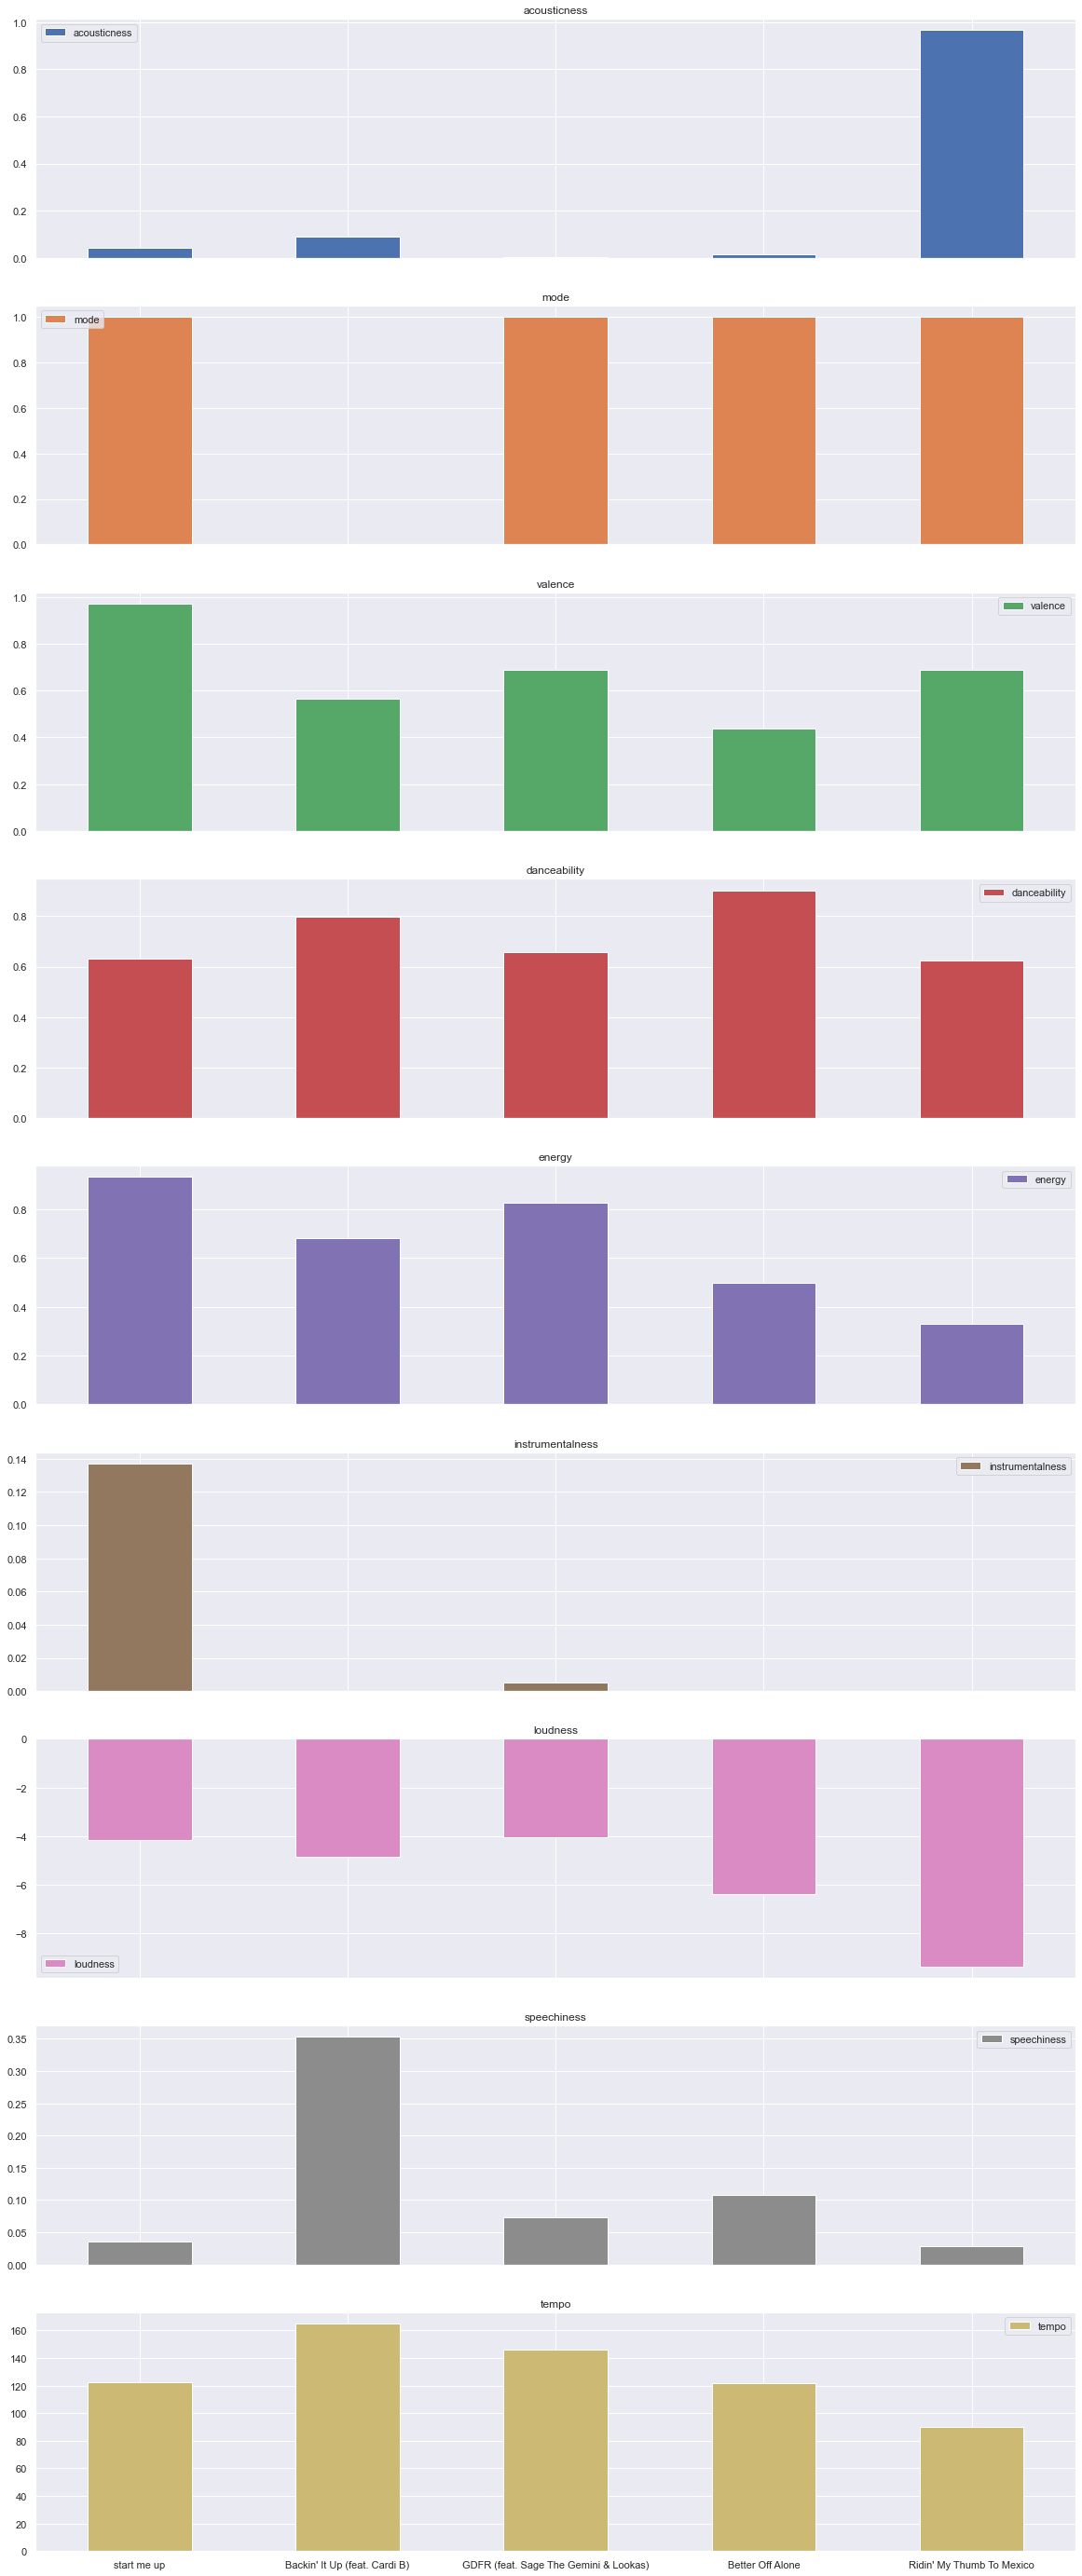

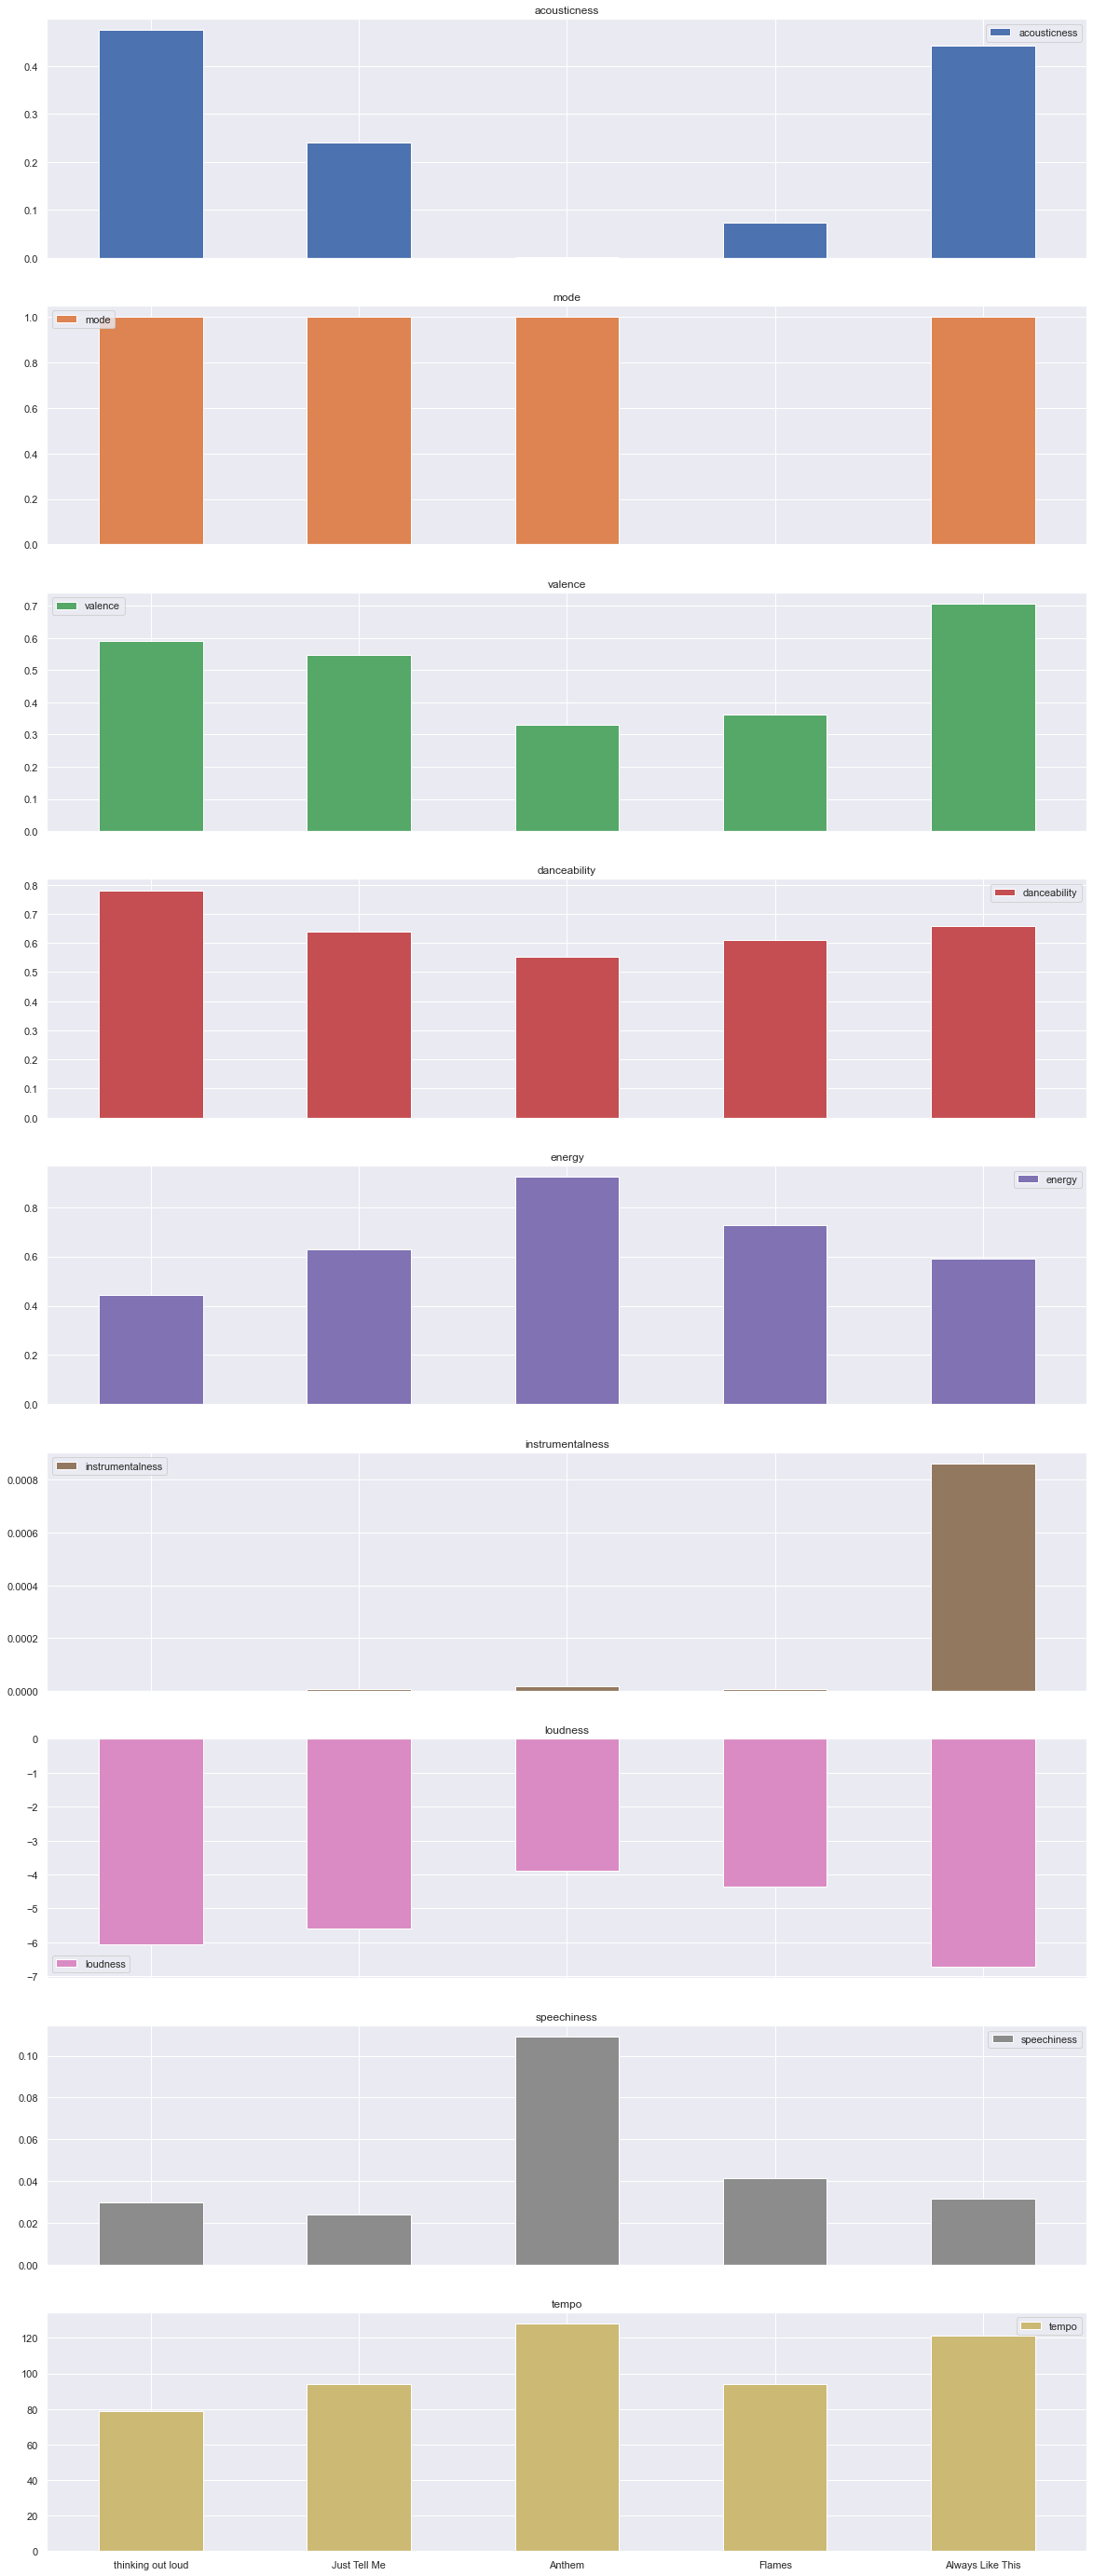

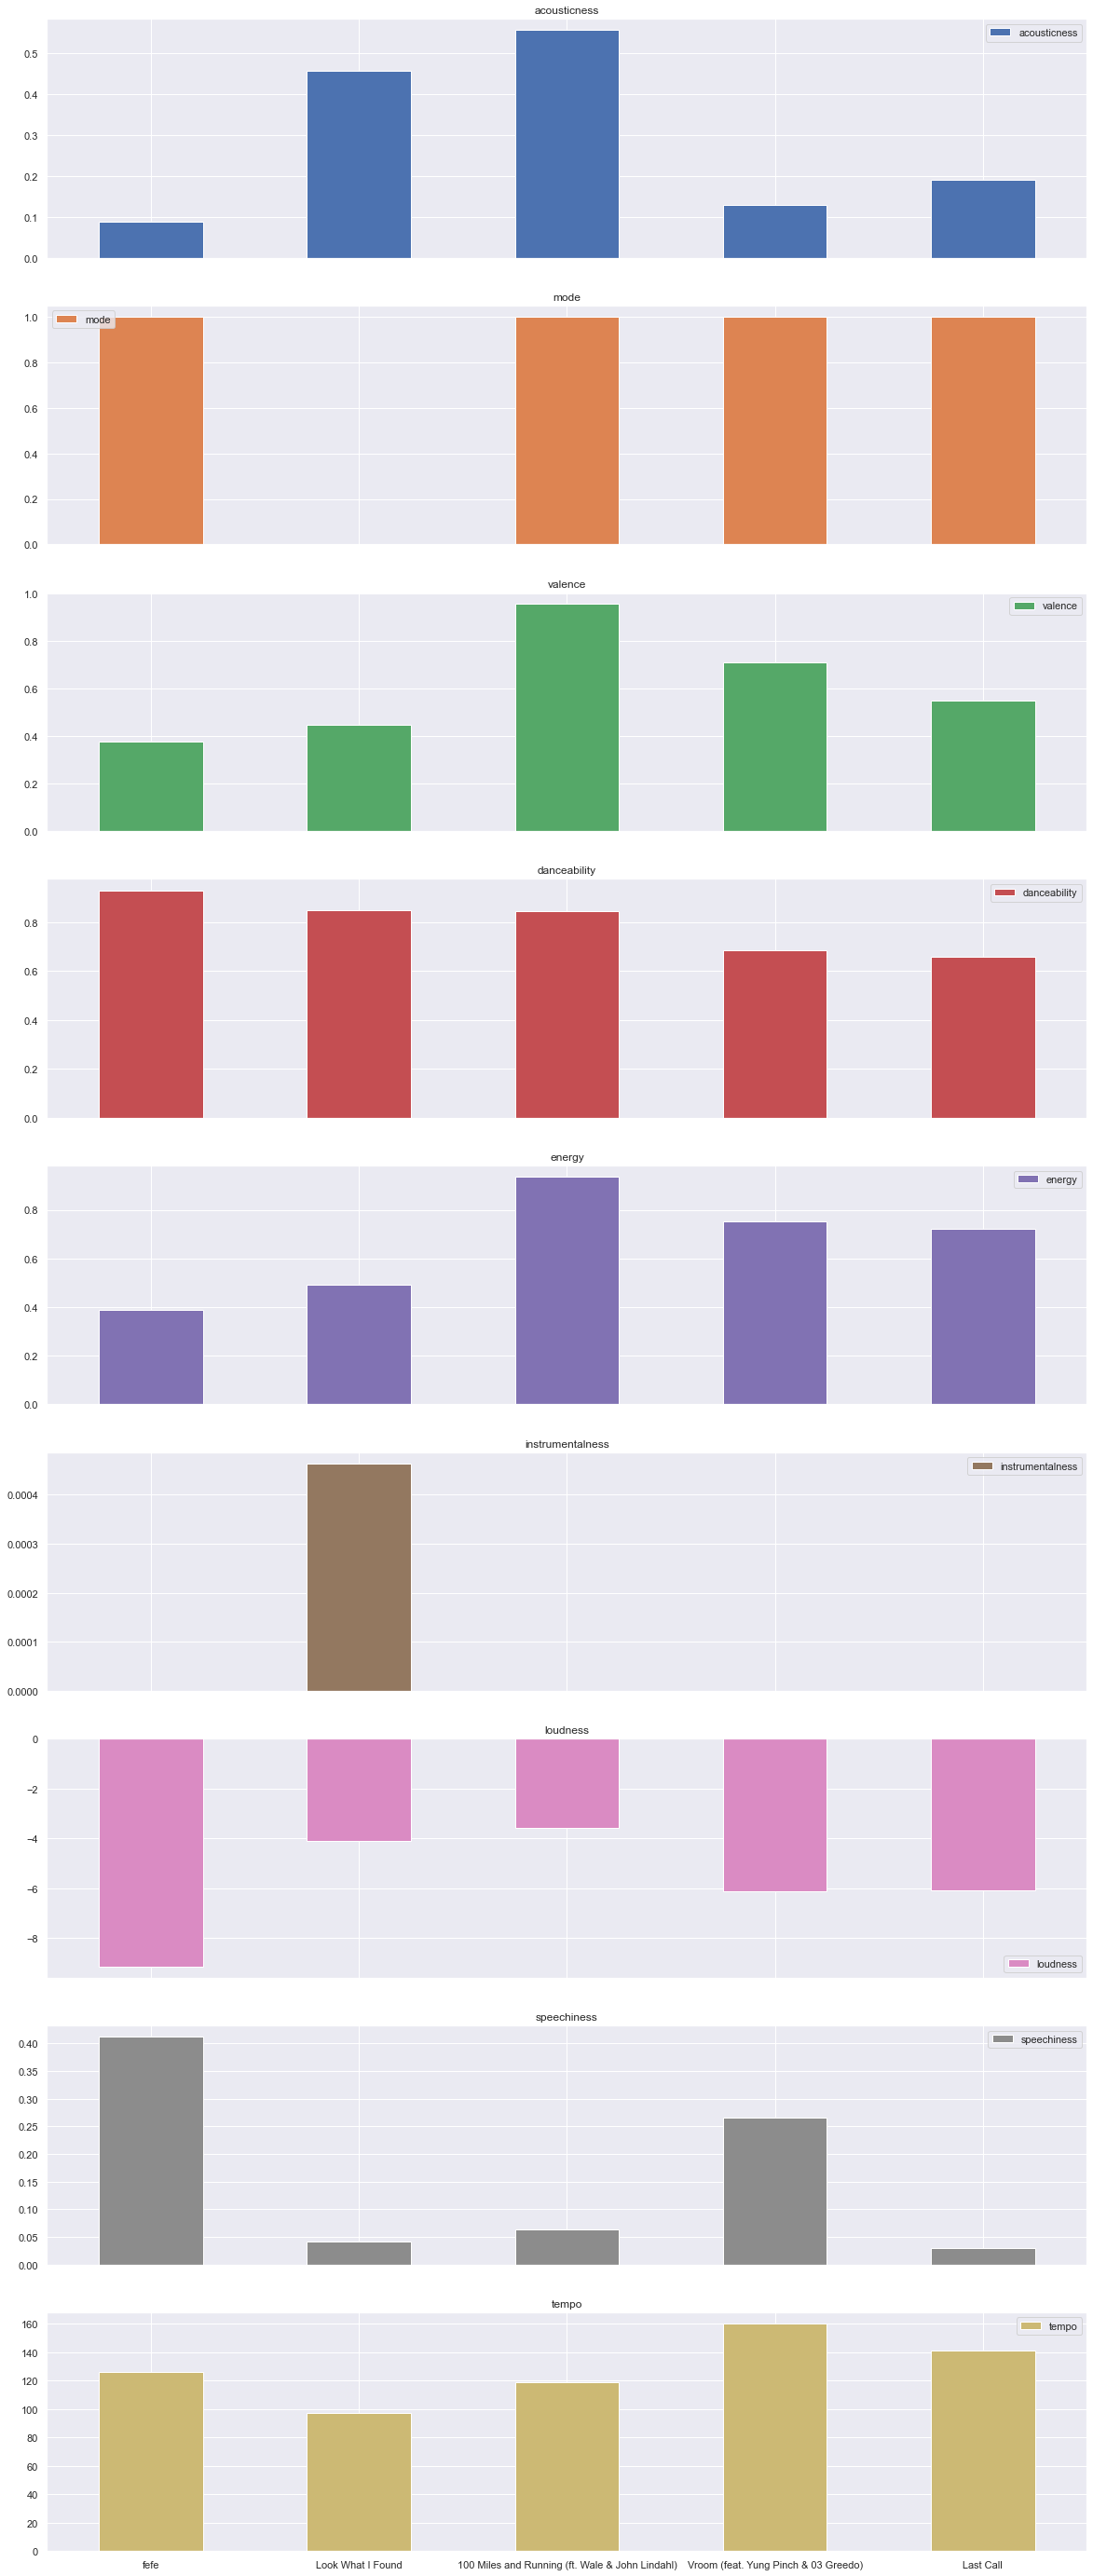

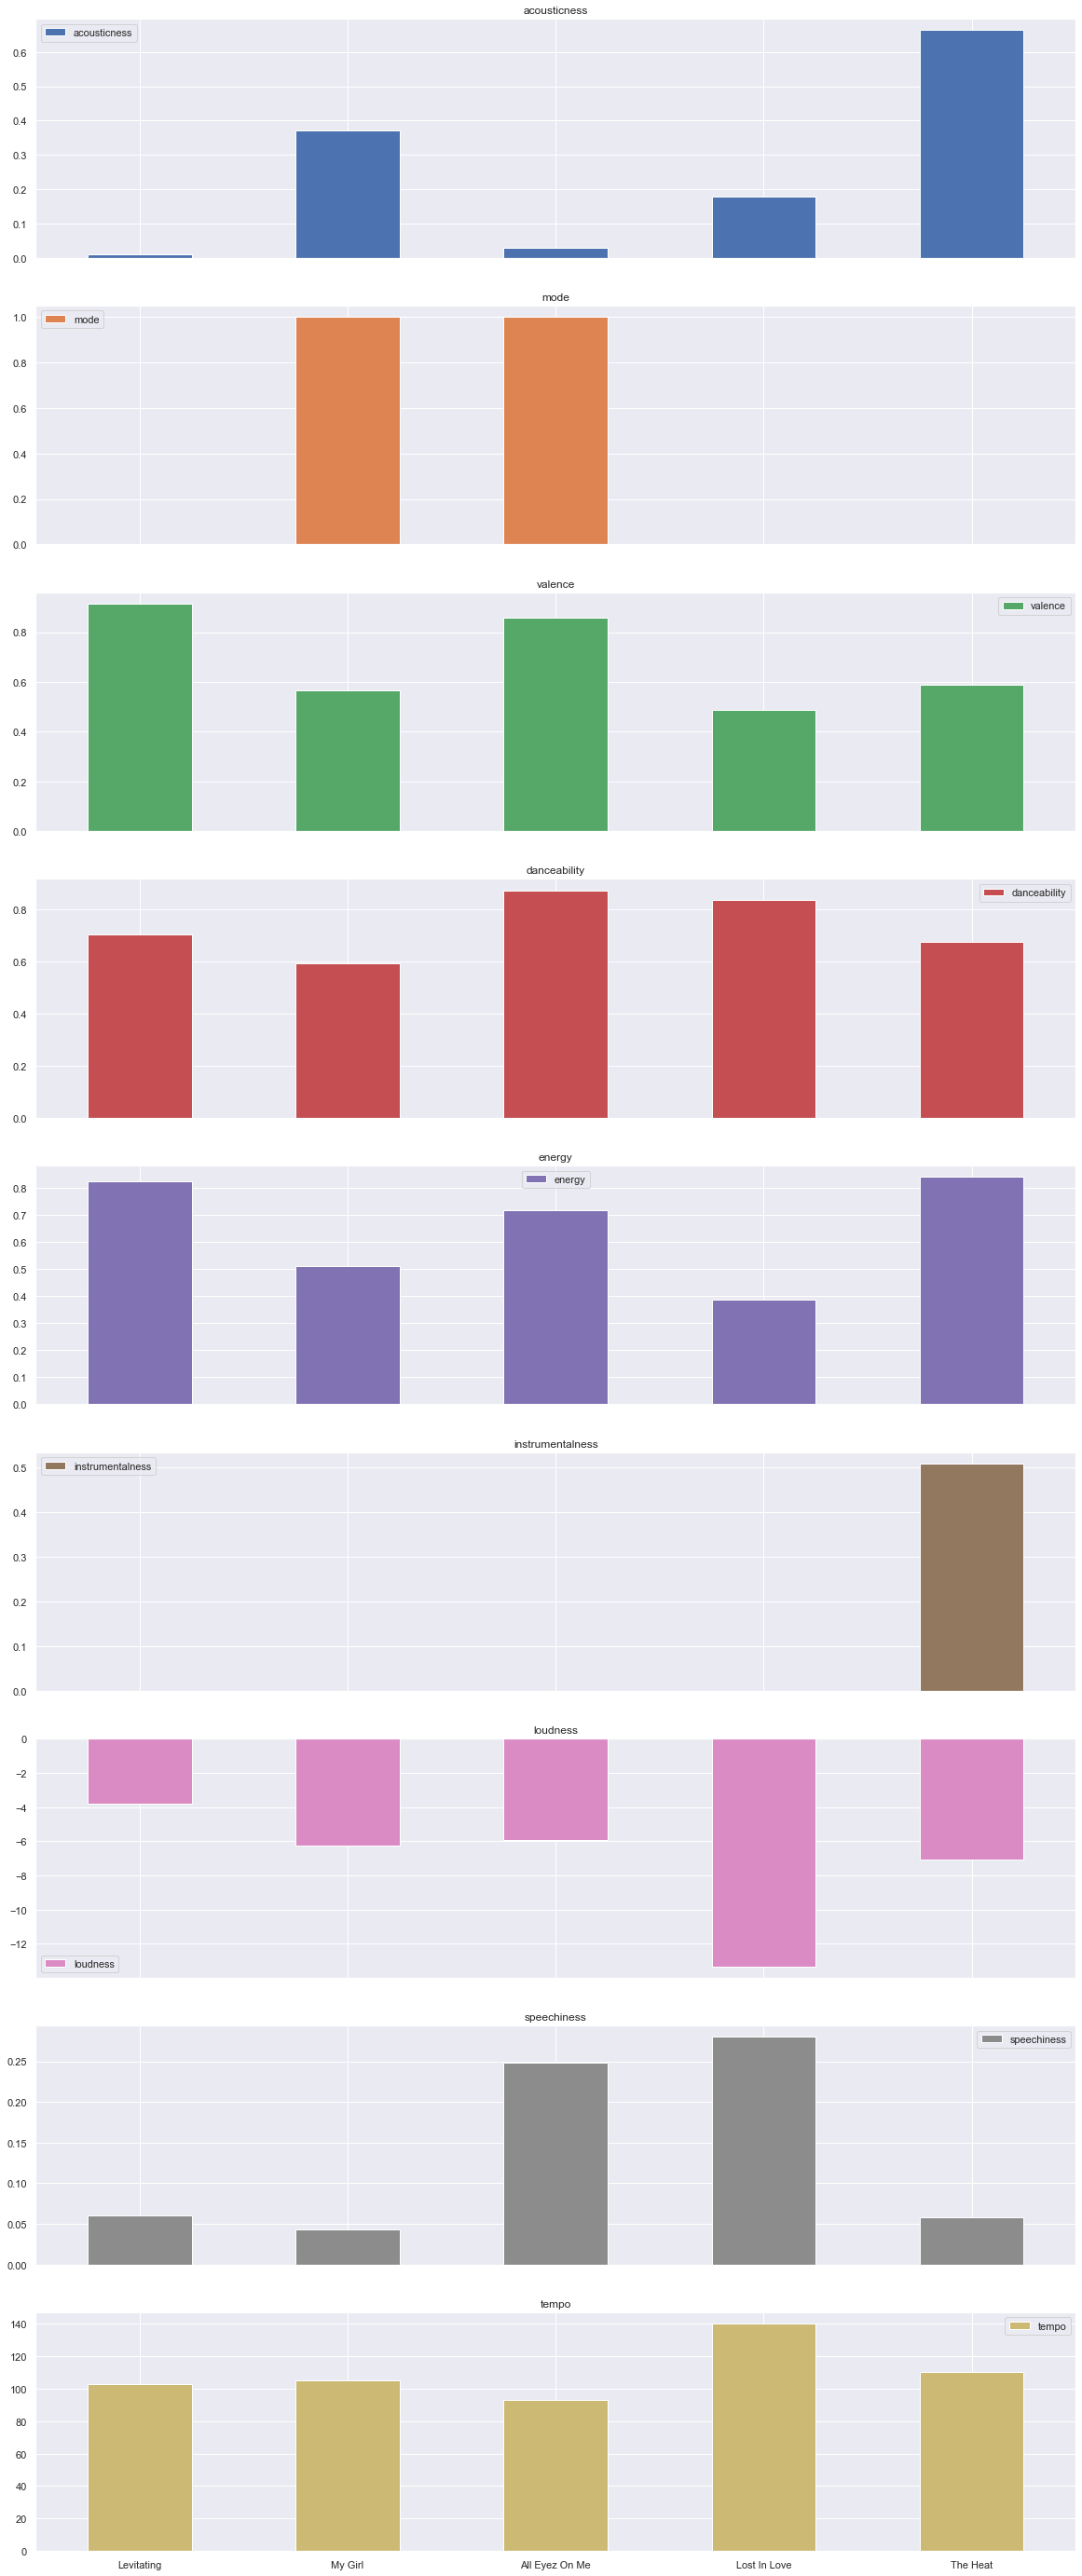

In [18]:
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html

# counter to go through features for input song data
counter1 = list(range(0,6))
counter2 = list(range(6,12))
counter3 = list(range(12,18))
counter4 = list(range(18,24))
counter = [counter1,counter2,counter3,counter4]
for count in counter:
    axes = df[count[0]:count[-1]].plot.bar(rot=0, subplots=True, figsize=(20,50))
    axes[1].legend(loc=2) 
    song_name = df[count[0]:count[-1]][:1].index.values[0]
    plt.savefig(f'features_plot_{song_name}.pdf') 

Now, to see an entire song comparison as a whole, the following graphs show each feature on the x axis with a bars of the same color representing a song. The following graphs plot the test song next to its top prediction for all features except tempo. We chose to exclude this feature as the scale was massive compared to the other features thus messing up the scale of the graph. Tempo however can be seen in the graphs above, thus for visual purposes only we excluded it from the following graphs. 

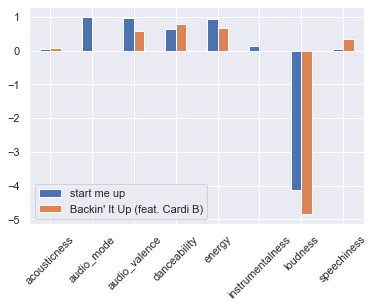

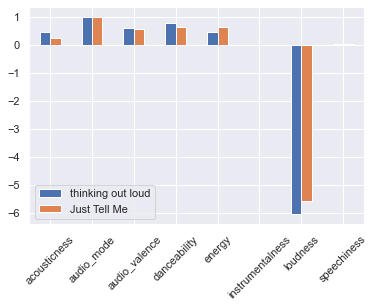

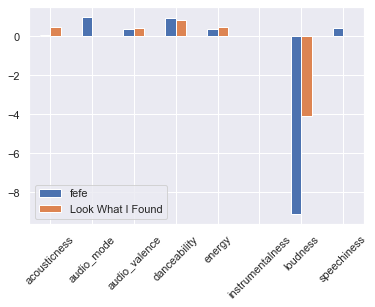

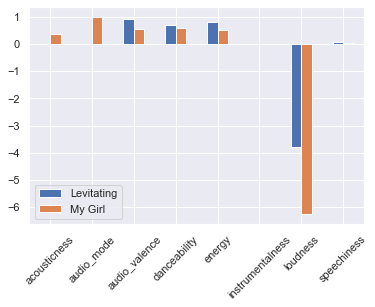

In [19]:
#plotting input with top song features side by side (excluding tempo)

#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html

# x features excluding tempo because the scale for tempo is too big
x_feats_2 = ['acousticness', 'audio_mode', 'audio_valence', 'danceability', 'energy', 
           'instrumentalness', 'loudness', 'speechiness']

# counter to go through features for input song data
counter1 = list(range(0,2))
counter2 = list(range(1,3))
counter3 = list(range(6,8))
counter4 = list(range(7,9))
counter5 = list(range(12,14))
counter6 = list(range(13,15))
counter7 = list(range(18,20))
counter8 = list(range(19,21))
counter_start = [counter1,counter3,counter5,counter7]
counter_end = [counter2,counter4,counter6,counter8]
for start,end in zip(counter_start,counter_end):
    df2 = pd.DataFrame({df[start[0]:start[-1]].index.values[0]:df[start[0]:start[-1]].values[0][:-1],
                    df[end[0]:end[-1]].index.values[0]:df[end[0]:end[-1]].values[0][:-1]},index=x_feats_2)
    ax = df2.plot.bar(rot=45)
    song_name = df[start[0]:start[-1]][:1].index.values[0]
    plt.savefig(f'comparison_plot_{song_name}.pdf') 

An interesting test is a song like Bohemian Rhapsody which has multiple varying musical features throughout the entire song. I have run the above graphs on the test song of Bohemian Rhapsody to analyze how our model works on a really tough,unique input song.

In [20]:
# testing on songs of all different genres
# building data lists to put in dataframe to visualization purposes

test_songs = ['bohemian rhapsody']
test_artists = ['queen']

# the x features we are using to predict based on plus song name
x_feats = ['song_name','acousticness', 'audio_mode', 'audio_valence', 'danceability', 'energy', 
           'instrumentalness', 'loudness', 'speechiness', 'tempo']

# initializing lists of features
index = []
acousticness = []
mode =  []
valence =  []
danceability =  []
energy =  []
instrumentalness =  []
loudness =  []
speechiness =  []
tempo =  []

# put data lists in an array
data = [index,acousticness,mode,valence,danceability,energy, instrumentalness,loudness,speechiness,tempo]

# counter to go through features for input song data
counter = list(range(0,11))

# go through every input song
for song,artist in zip(test_songs,test_artists):
    # get predictions
    songs,predictions,song_data = recommend_songs_visualization(song, artist)
    # add the data for the inputted song itself
    for data_list,count in zip(data,counter):
        # add song name 
        if count == 0:
            data_list.append(song)
        # add rest of features
        else:
            ct_idx = count-1
            data_list.append(song_data[0][ct_idx])
    # add all features for predicted songs
    for idx in range(5):
        for feat,data_list in zip(x_feats,data):
            data_list.append(predictions[idx:idx+1][feat].values[0])

In [21]:
# put all input songs and recommended songs with their features in a dataframe
df = pd.DataFrame({'acousticness': acousticness,
                   'mode': mode,'valence':valence,'danceability':danceability,'energy':energy,
                   'instrumentalness':instrumentalness,'loudness':loudness,'speechiness':speechiness,
                  'tempo':tempo}, index=index)
df

,acousticness,mode,valence,danceability,energy,instrumentalness,loudness,speechiness,tempo
bohemian rhapsody,0.28800,0.0,0.228,0.392,0.402,0.000000,-9.961,0.0536,143.883
Drops of Jupiter,0.15400,1.0,0.499,0.468,0.640,0.000000,-5.862,0.0275,79.297
New Religion,0.00185,1.0,0.514,0.535,0.851,0.000000,-4.370,0.0462,97.036
老派約會之必要-電視影集《雙城故事》插曲,0.16000,0.0,0.899,0.769,0.718,0.000000,-7.462,0.1690,98.029
Desire,0.72100,1.0,0.345,0.680,0.422,0.235000,-11.611,0.0439,90.036
I'll Be Missing You (feat. Faith Evans & 112),0.11100,1.0,0.901,0.833,0.619,0.000021,-5.595,0.0538,109.920


C:\Users\Gerri Fox\anaconda3\lib\site-packages\matplotlib\backends\_backend_pdf_ps.py:102: RuntimeWarning: Glyph 32769 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
C:\Users\Gerri Fox\anaconda3\lib\site-packages\matplotlib\backends\_backend_pdf_ps.py:102: RuntimeWarning: Glyph 27966 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
C:\Users\Gerri Fox\anaconda3\lib\site-packages\matplotlib\backends\_backend_pdf_ps.py:102: RuntimeWarning: Glyph 32004 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
C:\Users\Gerri Fox\anaconda3\lib\site-packages\matplotlib\backends\_backend_pdf_ps.py:102: RuntimeWarning: Glyph 26371 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
C:\Users\Gerri Fox\anaconda3\lib\site-packages\matplotlib\backends\_backend_pdf_ps.py:102: RuntimeWarning: Glyph 20043 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINT

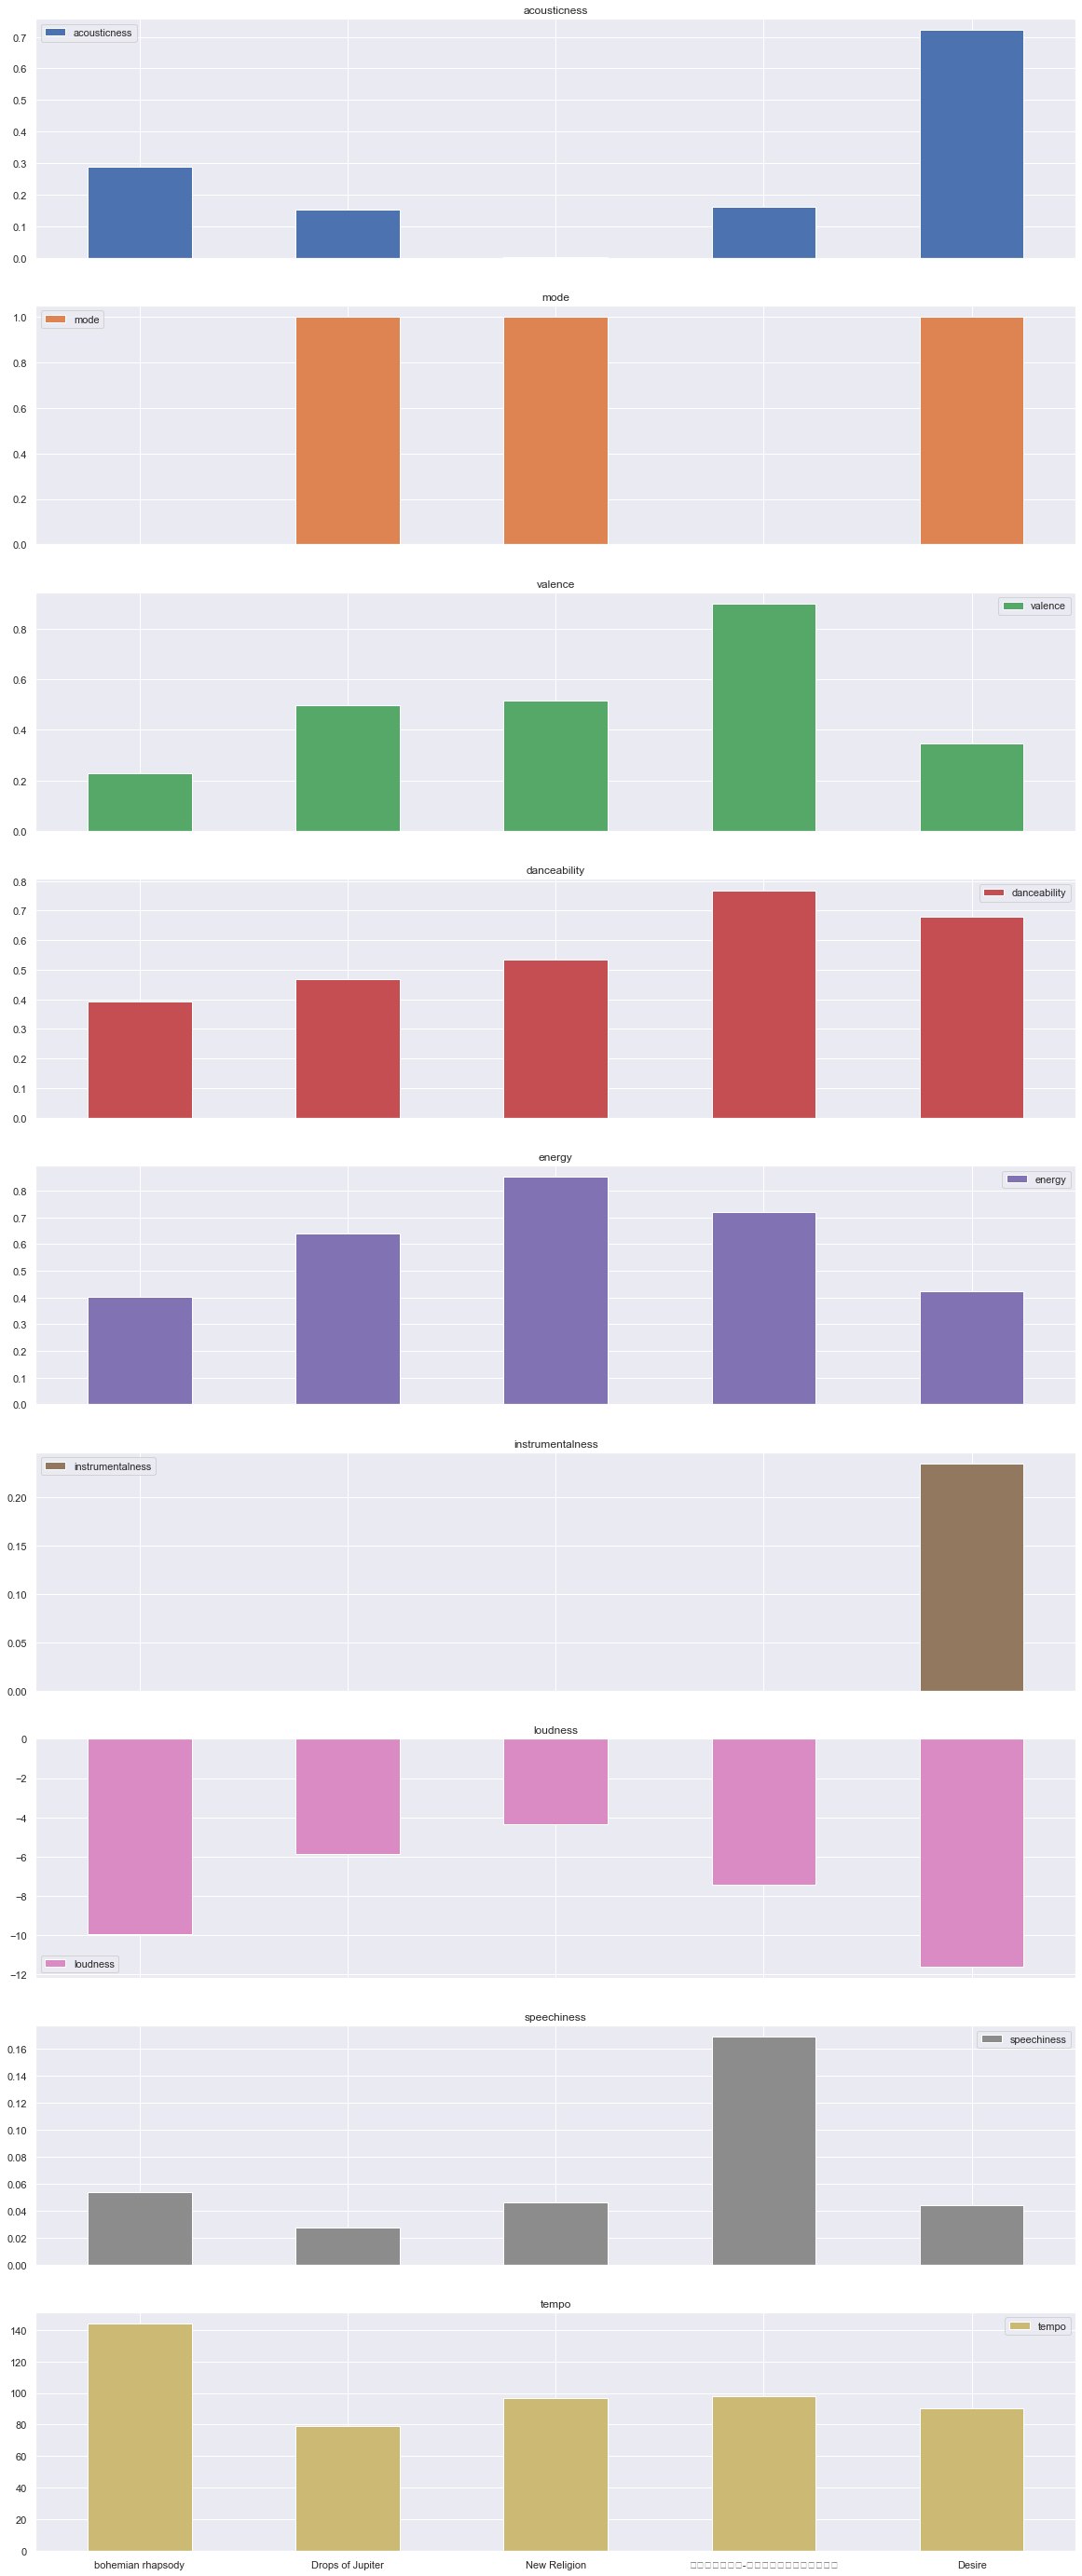

In [22]:
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html

# counter to go through features for input song data
counter1 = list(range(0,6))

counter = [counter1]
for count in counter:
    axes = df[count[0]:count[-1]].plot.bar(rot=0, subplots=True, figsize=(20,50))
    axes[1].legend(loc=2)  
    song_name = df[count[0]:count[-1]][:1].index.values[0]
    plt.savefig(f'features_plot_{song_name}.pdf') 

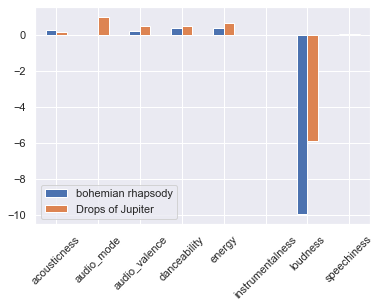

In [23]:
#plotting input with top song features side by side (excluding tempo)

#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html

# x features excluding tempo because the scale for tempo is too big
x_feats_2 = ['acousticness', 'audio_mode', 'audio_valence', 'danceability', 'energy', 
           'instrumentalness', 'loudness', 'speechiness']

# counter to go through features for input song data
counter1 = list(range(0,2))
counter2 = list(range(1,3))

counter_start = [counter1]
counter_end = [counter2]
for start,end in zip(counter_start,counter_end):
    df2 = pd.DataFrame({df[start[0]:start[-1]].index.values[0]:df[start[0]:start[-1]].values[0][:-1],
                    df[end[0]:end[-1]].index.values[0]:df[end[0]:end[-1]].values[0][:-1]},index=x_feats_2)
    ax = df2.plot.bar(rot=45)
    song_name = df[start[0]:start[-1]][:1].index.values[0]
    plt.savefig(f'comparison_plot_{song_name}.pdf')

Analyzing the graphs above, the variance in features difference is clearly present, however, the other test songs also are not perfectly matched. We think this shows the difficulty in recommending music solely based on features as every song is always unique and there will never be perfect matches, and one person may really enjoy songs that are opposites. 

# Dicussion

Our project is semi successful with a few flaws that are expected and faced within the industry as well, as discussed below:

1. An interesting observation we have made from analyzing our results is how the data interprets popularity. Our intention of filtering by popularity was to recommend not well known music. However, the popularity measurement seems to be reflective of time as well. Songs that are pretty well known and popular years ago are not being flagged as "popular" solely based on their release time. **We'd suggest adding functionality for the user to decide if they want to filter by release date as well.**
    - This leads to an interesting question of whether music that was popular 20 years ago has the same features as music popular today. When inputting an old song, it would recommend similar songs released around the same date that we would classify as "well-known." We believe that the Spotify popularity measurement must be related to streams or release date or charts as older songs are less likely to be streamed as often as popular songs released recently for many factors, one potentially being the listeners may not be using this platform to listen for example.


2. When testing, we were thinking of a song that is well-known, and by chance Bohemian Rhapsody by Queen was mentioned and decided upon. However, after further thought, this was probably not the best song choice as this song in itself has many quite differing musical features within its duration thus being confusing for the predictor as the features must just be an average from throughout the song which in this case probably isn't reflective of its actual sound. **This is a challenge with any song recommender and is something that does not lend itself well to K-Nearest Neighbors, however this is not a typical case.**
    - To further evaluate this, we tested on songs of different genres to ensure that at least songs that are classified under a main genre are getting predictions relatively within the same genre. This is also challenging as similar with Bohemian Rhapsody, some songs are labelled under multiple genres, so this isn't quite a reliable feature either.


3. Our song database is from the Kaggle dataset thus may obviously not be complete and not include every possible obscure song which can be conflicting with our intention of trying to recommend lesser known songs. However, when we filtered by popularity about 40% of the songs in the dataset were removed which does hold consistent with our Gaussian distribution and prediction for roughly how much would be removed. **We'd suggest trying to pull from Spotify itself and filtering straight from there.**


4. To enhance our music recommender, perhaps we could add functionality to recommend songs that are opposites, i.e. farthest distances away, or allow the user to input a genre or filter by a specific feature that is most important to them to make our predictor more personal. **It is impossible to find all perfect matches as if this were the case would probably mean there is are bigger issues such as copyright issues.**


## Takeaway

Overall, we believe that our predictor may not be the most accurate but from user testing and validation, for the most part, is predicting songs that are least similar and that the user enjoys. Although it may not be the most accurate and not quite yet ready for widespread proprietary use, it is still a decent way to get new music suggestions. Perhaps it is best at taking a risk by predicting songs similar enough that you may like, but are not exactly spot on. 